# Time to build a good model
After our first success, we will create and tune a better model and get a better understanding of how good it is.

In [1]:
import pandas as pd
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#As always, we need to load our data (file name: race_df_with_advanced_features.pkl):
race_df = pd.read_pickle('race_df_with_advanced_features.pkl')
race_df.head(5)

qgrid_pos  Nr.       Driver      Team  fp2_pos     fp2_t  fp3_pos  \
0          3    8    F. Alonso   Ferrari      9.0  117140.0      1.0   
1          2    7     F. Massa   Ferrari      7.0  116555.0      6.0   
2          4    2  L. Hamilton   McLaren      2.0  115854.0     12.0   
3          1    5    S. Vettel  Red Bull      5.0  116459.0      5.0   
4          5    4   N. Rosberg  Mercedes      1.0  115409.0      2.0   

      fp3_t  fp1_pos     fp1_t  ...  hist_fp2_pos  hist_fp3_pos  hist_fp1_pos  \
0  114099.0      2.0  116766.0  ...           NaN           NaN           NaN   
1  114739.0      4.0  117055.0  ...           NaN           NaN           NaN   
2  115860.0      6.0  117163.0  ...           NaN           NaN           NaN   
3  114646.0     13.0  117943.0  ...           NaN           NaN           NaN   
4  114368.0      8.0  117199.0  ...           NaN           NaN           NaN   

   hist_q_pos  hist_race_pos  best_fp_pos  worst_fp_pos mean_fp_pos  \
0         NaN            NaN          1.0           3.0         2.0   
1         NaN            NaN          6.0           1.0         5.0   
2         NaN            NaN         12.0           4.0         6.0   
3         NaN            NaN          5.0          10.0         7.0   
4         NaN            NaN          2.0           5.0         1.0   

   r_hist_qgrid_pos_2_fp  r_hist_race_pos_2_fp  
0                    NaN                   NaN  
1                    NaN                   NaN  
2                    NaN                   NaN  
3                    NaN                   NaN  
4                    NaN                   NaN  

[5 rows x 50 columns]

In [3]:
sorted(race_df.columns)

['Driver',
 'Nr.',
 'Team',
 'best_fp_pos',
 'best_fp_t',
 'champ_points',
 'finished_race',
 'fp1_pos',
 'fp1_t',
 'fp2_pos',
 'fp2_t',
 'fp3_pos',
 'fp3_t',
 'hist_fp1_pos',
 'hist_fp2_pos',
 'hist_fp3_pos',
 'hist_q_pos',
 'hist_qgrid_pos',
 'hist_race_pos',
 'is_Alfa Romeo',
 'is_AlphaTauri',
 'is_Alpine',
 'is_Aston Martin',
 'is_Caterham',
 'is_Ferrari',
 'is_HRT',
 'is_Haas F1',
 'is_Lotus',
 'is_Manor',
 'is_McLaren',
 'is_Mercedes',
 'is_Red Bull',
 'is_Williams',
 'mean_fp_pos',
 'mean_fp_t',
 'pos_gained',
 'q_pos',
 'q_t',
 'qgrid_pos',
 'r_hist_qgrid_pos_2_fp',
 'r_hist_race_pos_2_fp',
 'race_idx',
 'race_name',
 'race_num',
 'race_pos',
 'v_m_s',
 'velocity',
 'worst_fp_pos',
 'worst_fp_t',
 'year']

## Selecting features:
This time, we will select as many features as possible.<br>
Lets make them thos that start with <i>r_</i>, <i>hist_</i> and <i>is_</i> or end with <i>_pos</i>.

In [4]:
feature_columns = [col for col in race_df.columns if ((col.startswith(('r_','hist_','is_'))) or (col.endswith('pos')))]
#We have to exclude some again, remember, we want to predict the race after free practice 3:
feature_columns.remove('race_pos')
feature_columns.remove('qgrid_pos')
feature_columns.remove('q_pos')
sorted(feature_columns)

['best_fp_pos',
 'fp1_pos',
 'fp2_pos',
 'fp3_pos',
 'hist_fp1_pos',
 'hist_fp2_pos',
 'hist_fp3_pos',
 'hist_q_pos',
 'hist_qgrid_pos',
 'hist_race_pos',
 'is_Alfa Romeo',
 'is_AlphaTauri',
 'is_Alpine',
 'is_Aston Martin',
 'is_Caterham',
 'is_Ferrari',
 'is_HRT',
 'is_Haas F1',
 'is_Lotus',
 'is_Manor',
 'is_McLaren',
 'is_Mercedes',
 'is_Red Bull',
 'is_Williams',
 'mean_fp_pos',
 'r_hist_qgrid_pos_2_fp',
 'r_hist_race_pos_2_fp',
 'worst_fp_pos']

In [5]:
y_column = 'race_pos'

## Drop NaNs
Most ML models do not like NaN values.<br>
We will have to count them, to make sure not to drop 90% of the data,<br>
then drop the rows containing a NaN

In [6]:
rows_before_drop = race_df.shape[0]
race_df = race_df[feature_columns+[y_column,'year','race_idx','Driver']].dropna()#Drop the rows containing a NaN
rows_post_drop = race_df.shape[0]
rows_lost = rows_before_drop - rows_post_drop
print(f'We lost {rows_lost} of initialy {rows_before_drop} rows.\n{int(rows_lost/rows_before_drop*100)}% lost')

We lost 1200 of initialy 4718 rows.
25% lost


### Split our data to test and training.
As we are using gliding averages, it might not be a good idea to<br>
randomly sample. We will use the year 2020 as cut-off:

In [7]:
#Split to training and test data by using the year 2020 as filter:
X_train = race_df[race_df['year']<2020][feature_columns]
y_train = race_df[race_df['year']<2020][y_column]

X_test = race_df[race_df['year']<=2020][feature_columns]
y_test = race_df[race_df['year']<=2020][y_column]

## Building a new and better(?) model and fitting the data to it:
This time, we will opt for Gradient Boosted Regression

In [8]:
gbr = GradientBoostingRegressor(learning_rate=0.2,max_depth=3)

gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## Predicting data with our model

In [9]:
y_pred = gbr.predict(X_test)

## Looking at the numbers:

In [10]:
print(f'\nMean squared error: \t\t{mean_squared_error(y_test, y_pred)}')#Slash n starts a new line
print(f'Coefficient of determination: \t{r2_score(y_test, y_pred)}')# Slash t is a tab


Mean squared error: 		6.699554603045929
Coefficient of determination: 	0.7673233978626416


##### We are a much better than before!!!<br><br>
##### Are we too good now or can we get even better?

## Hyper parameter tuning:
You might have noticed the <i>learning_rate</i> and <i>max_depth=3</i> parameters when setting up the regressor.<br>
Play around with it and see what happens to our accuracy metrics.<br>
How about using a loop and printing the results?


In [11]:
for max_d in range(2,25):
    gbr.max_depth = max_d
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    
    msq = mean_squared_error(y_test, y_pred)
    cd = r2_score(y_test, y_pred)
    print(f'For Max depth: {max_d} - meansqderror: {msq} - det coef: {cd}')

For Max depth: 2 - meansqderror: 8.144811424932165 - det coef: 0.717129397446638
For Max depth: 3 - meansqderror: 6.690851777544611 - det coef: 0.7676256483832539
For Max depth: 4 - meansqderror: 5.165951558230074 - det coef: 0.8205856767211537
For Max depth: 5 - meansqderror: 3.4354518155103793 - det coef: 0.880686209367388
For Max depth: 6 - meansqderror: 2.07140839967365 - det coef: 0.9280596552111504
For Max depth: 7 - meansqderror: 1.3872050557362499 - det coef: 0.9518221467006585
For Max depth: 8 - meansqderror: 0.9213814727391165 - det coef: 0.968000274189603
For Max depth: 9 - meansqderror: 0.8483060410712802 - det coef: 0.970538195610896
For Max depth: 10 - meansqderror: 0.8907735567048369 - det coef: 0.9690632920054626
For Max depth: 11 - meansqderror: 0.7680936861455437 - det coef: 0.9733239835176132
For Max depth: 12 - meansqderror: 0.8011241253594339 - det coef: 0.9721768310845398
For Max depth: 13 - meansqderror: 0.7932580171141308 - det coef: 0.9724500222811201
For Max d

Looks like a max depth around 11 produces the best results.

## Detecting overfitting
An accuracy metric for the test way better than what was seen in training, indicates overfitting.
So, lets add the same accurcay scores for the training predictions. We will append the results to a dataframe and then plot the results with Seaborn.

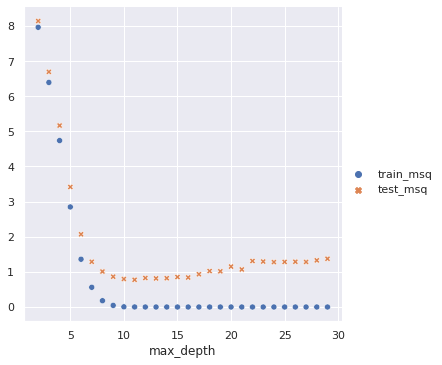

In [12]:
#Create a loop to try different max_depth values, append the results to the dataframe and plot it
accuracy_df = pd.DataFrame({'max_depth':[],'train_msq':[],'train_cd':[],'test_msq':[],'test_cd':[]})
for max_d in range(2,30):
    gbr.max_depth = max_d
    gbr.fit(X_train, y_train)
    y_pred_train = gbr.predict(X_train)
    y_pred_test = gbr.predict(X_test)
    
    train_msq = mean_squared_error(y_train, y_pred_train)
    train_cd = r2_score(y_train, y_pred_train)
    
    test_msq = mean_squared_error(y_test, y_pred_test)
    test_cd = r2_score(y_test, y_pred_test)
    
    accuracy_df = accuracy_df.append({'max_depth':max_d,
                                      'train_msq':train_msq,
                                      'train_cd':train_cd,
                                      'test_msq':test_msq,
                                      'test_cd':test_cd},
                                       ignore_index=True)
    
    
#Plot the accuracy_df data frame
accuracy_df = accuracy_df.set_index('max_depth')
sns.set(rc={"figure.figsize":(18, 8)})

sns.relplot(data=accuracy_df[['train_msq','test_msq']])

Looks like the curve starts diveriging at a max depth of about 4, definitively after 10.
We will fix the max depth at 9 for now.

## Feature Importance
Adding every feature, you can find into a model, might on paper improve certain accuracy metrics.<br>
In reality they can cause all kinds of issues.<br>
Lets have a look at the feature importances in our model and<br>
decide if we can kick some out.<br>

In [13]:
gbr.max_depth = 9
gbr.fit(X_train, y_train)
feature_importance_df = pd.DataFrame({'Features':X_train.columns,'importance':gbr.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='importance',ascending=False).reset_index(drop=True)

In [14]:
feature_importance_df.head(5)

Features  importance
0     hist_q_pos    0.295974
1    best_fp_pos    0.183201
2  hist_race_pos    0.130408
3   hist_fp3_pos    0.104958
4   hist_fp2_pos    0.046807

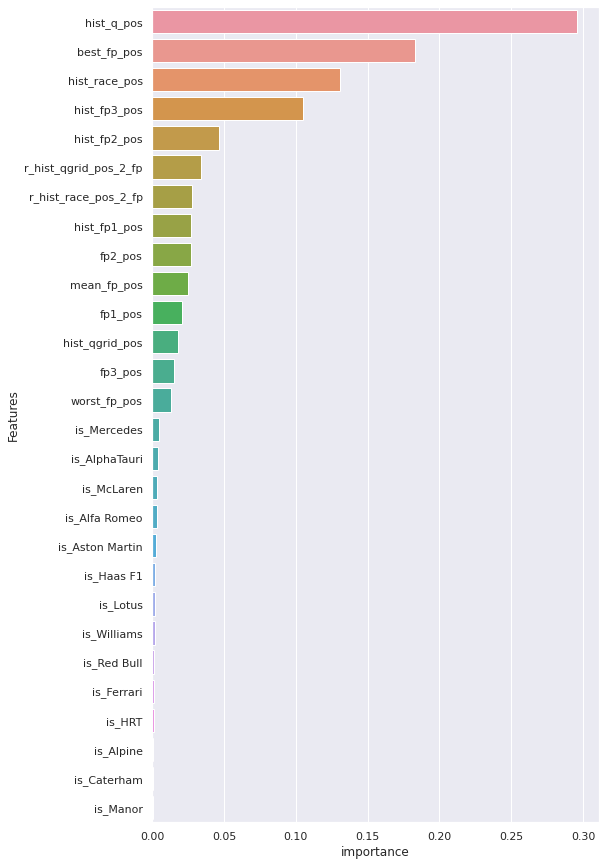

In [15]:
sns.set(rc={"figure.figsize":(8, 15)})
barplot = sns.barplot(data=feature_importance_df,x='importance',y='Features')

#### OK, so we will keep about the 14 most important features...<br>
and see what it does to our model.<br>
Keep in mind, that descission tress are very robust against too many features.<br>
Other models might profit more from this approach.<br>

In [16]:
#Read the initial data once more, to make sure it is fresh:
race_df = pd.read_pickle('race_df_with_advanced_features.pkl')

#Select the 14 top features into a list:
new_features = feature_importance_df.iloc[0:14]['Features'].to_list()
new_features

['hist_q_pos',
 'best_fp_pos',
 'hist_race_pos',
 'hist_fp3_pos',
 'hist_fp2_pos',
 'r_hist_qgrid_pos_2_fp',
 'r_hist_race_pos_2_fp',
 'hist_fp1_pos',
 'fp2_pos',
 'mean_fp_pos',
 'fp1_pos',
 'hist_qgrid_pos',
 'fp3_pos',
 'worst_fp_pos']

As we know that some of these features contain many NaNs, lets remove those with many NaN that do not appear to be very important

In [17]:
#Calculate and display NaN values:
race_df.isna().sum()[new_features]


hist_q_pos                71
best_fp_pos                0
hist_race_pos            104
hist_fp3_pos              71
hist_fp2_pos              73
r_hist_qgrid_pos_2_fp     71
r_hist_race_pos_2_fp     104
hist_fp1_pos              76
fp2_pos                   84
mean_fp_pos                0
fp1_pos                  290
hist_qgrid_pos            71
fp3_pos                   62
worst_fp_pos               0
dtype: int64

In [18]:
#Remove the ones with too many NaNs again:
new_features.remove('hist_fp1_pos')
new_features.remove('hist_fp2_pos')
new_features.remove('hist_q_pos')
new_features.remove('hist_qgrid_pos')


In [19]:
#Run the model with the "best" max depth and fit with the reduced set of features:
gbr.max_depth = 9
gbr.fit(X_train[new_features], y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_depth=9,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
#Predict the results:
y_pred = gbr.predict(X_test[new_features])

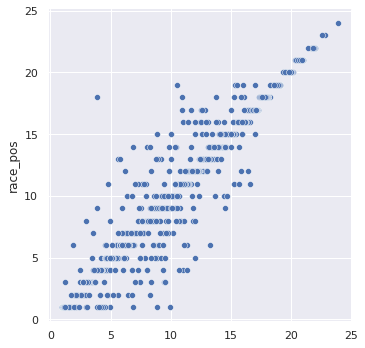

In [21]:
#Plot the results in a scatter plot
sns.relplot(x=y_pred,y=y_test)

In [22]:
#And now calculate or accuracy measurements:
print(f'\nMean squared error: \t\t{mean_squared_error(y_test, y_pred)}')#Slash n starts a new line
print(f'Coefficient of determination: \t{r2_score(y_test, y_pred)}')# Slash t is a tab


Mean squared error: 		0.8698600218540892
Coefficient of determination: 	0.9697896224133886


We got pretty good! Lets see how the latest predictions hold up with real world results:

In [23]:
race_df['race_idx'].max()

202101

In [24]:
X = race_df[race_df['race_idx']==202101].dropna(subset=new_features)
X 

qgrid_pos  Nr.         Driver          Team  fp2_pos    fp2_t  fp3_pos  \
4698          2   44    L. Hamilton      Mercedes      3.0  91082.0      2.0   
4699          1   33  M. Verstappen      Red Bull      1.0  90847.0      1.0   
4700          3   77      V. Bottas      Mercedes      5.0  91218.0      4.0   
4701          7    4      L. Norris       McLaren      2.0  90942.0     16.0   
4702         11   11       S. Perez      Red Bull     10.0  91503.0      5.0   
4703          4   16     C. Leclerc       Ferrari     12.0  91612.0     11.0   
4704          6    3   D. Ricciardo       McLaren      6.0  91230.0     10.0   
4705          8   55       C. Sainz       Ferrari      4.0  91127.0      6.0   
4707         10   18      L. Stroll  Aston Martin      8.0  91393.0      9.0   
4708         14    7   K. Räikkönen    Alfa Romeo     16.0  91862.0      7.0   
4709         12   99  A. Giovinazzi    Alfa Romeo     13.0  91740.0     12.0   
4710         16   31        E. Ocon        Alpine     11.0  91601.0      8.0   
4711         15   63     G. Russell      Williams     17.0  92331.0     17.0   
4712         20    5      S. Vettel  Aston Martin     14.0  91769.0     14.0   
4713         18   47  M. Schumacher       Haas F1     18.0  93297.0     18.0   
4714          5   10       P. Gasly    AlphaTauri      9.0  91483.0      3.0   
4715         17    6      N. Latifi      Williams     19.0  93400.0     20.0   
4716          9   14      F. Alonso        Alpine     15.0  91770.0     15.0   

        fp3_t  fp1_pos    fp1_t  ...  hist_fp2_pos  hist_fp3_pos  \
4698  91316.0      4.0  91921.0  ...      3.750000      6.400000   
4699  90577.0      1.0  91394.0  ...      2.000000      1.400000   
4700  91855.0      2.0  91692.0  ...      3.800000      4.600000   
4701  92860.0      3.0  91897.0  ...      8.400000      6.200000   
4702  91908.0      6.0  92071.0  ...      7.400000      8.600000   
4703  92482.0      5.0  91993.0  ...      9.600000      9.600000   
4704  92477.0      9.0  92434.0  ...     10.000000     10.600000   
4705  92108.0      8.0  92366.0  ...     10.800000      8.400000   
4707  92431.0     13.0  93233.0  ...     10.600000     10.200000   
4708  92224.0     11.0  93134.0  ...     14.800000     16.200000   
4709  92500.0     10.0  92786.0  ...     15.600000     14.200000   
4710  92423.0     15.0  93528.0  ...      8.400000      6.800000   
4711  93323.0     17.0  94127.0  ...     13.400000     14.200000   
4712  92755.0     12.0  93157.0  ...     11.400000     11.800000   
4713  93422.0     19.0  94501.0  ...      9.666667     11.166667   
4714  91583.0      7.0  92195.0  ...      8.400000      8.000000   
4715  93959.0     18.0  94340.0  ...     17.400000     19.000000   
4716  92820.0     16.0  93872.0  ...     13.833333     17.666667   

      hist_fp1_pos  hist_q_pos  hist_race_pos  best_fp_pos  worst_fp_pos  \
4698      4.800000    2.500000       1.333333          3.0           3.0   
4699      2.500000    2.500000       3.000000          1.0           1.0   
4700      3.500000    2.833333       6.000000          5.0           2.0   
4701     13.666667    9.333333       8.000000          2.0          10.0   
4702      8.666667    7.333333       6.800000         10.0           4.0   
4703      7.500000    8.333333       7.200000         12.0           8.0   
4704     12.000000    7.500000       6.833333          6.0           7.0   
4705     11.166667    9.833333       5.500000          4.0           6.0   
4707     10.666667    9.833333       8.750000          8.0          13.0   
4708     13.000000   15.666667      12.666667         16.0          11.0   
4709     14.000000   15.166667      14.000000         13.0           9.0   
4710      9.000000    9.833333       7.800000         11.0          15.0   
4711     14.600000   13.166667      13.200000         17.0          17.0   
4712     10.333333   13.000000      10.666667         14.0          12.0   
4713      8.833333   11.833333      13.333333       

In [25]:
X['y_pred'] = gbr.predict(X[new_features])

In [26]:
X[['Driver','y_pred','race_pos']].sort_values(by='y_pred')

Driver     y_pred  race_pos
4699  M. Verstappen   2.385092       2.0
4698    L. Hamilton   2.984287       1.0
4705       C. Sainz   3.823496       8.0
4700      V. Bottas   4.200561       3.0
4714       P. Gasly   5.947272      17.0
4702       S. Perez   6.983583       5.0
4701      L. Norris   7.205128       4.0
4703     C. Leclerc   8.413683       6.0
4712      S. Vettel   9.853773      15.0
4710        E. Ocon   9.900178      13.0
4708   K. Räikkönen  11.032340      11.0
4704   D. Ricciardo  12.120267       7.0
4709  A. Giovinazzi  12.388800      12.0
4713  M. Schumacher  12.642195      16.0
4707      L. Stroll  13.203392      10.0
4716      F. Alonso  13.350286       NaN
4711     G. Russell  14.192884      14.0
4715      N. Latifi  16.326779      18.0

https://results.motorsportstats.com/results/2020-portuguese-grand-prix/classification

### If you still have time left over:
Improve the plots in this notebook.<br>
Or if you are very fast, improve the model, get it even better.<br>
There are many more features waiting to get engineered and many more hyper parameters this model wants to have tuned.<br>
Have fun!